<a href="https://colab.research.google.com/github/222luke/COMPEVOL/blob/main/MOPSO_NSGA_Otimiza%C3%A7%C3%A3o_de_Microrrede_H%C3%ADbrida.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Otimização de Microrrede Híbrida**

**Docente:** Prof. Dr. Edmar Egídio Purcino de Souza

**Discentes:** André Paiva, Gabriel Lucas e Márcio Barros


In [ ]:
# === INSTALAÇÃO E IMPORTS ===
!pip install pvlib
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pvlib
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.pvsystem import PVSystem
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 77.9 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
import warnings

# Supressing shapely warnings that occur on import of pvfactors
warnings.filterwarnings(action='ignore', module='pvfactors')

# Definição de localização do sistema
location = Location(latitude=-12.709714, longitude=-38.175534, tz='America/Bahia', altitude=400, name='Cimatec Park')

# Importa biblioteca dos parâmetros elétricos dos módulos fotovoltaicos e inversores do GitHub
cec_modules = pvlib.pvsystem.retrieve_sam(path='https://raw.githubusercontent.com/NREL/SAM/patch/deploy/libraries/CEC%20Modules.csv')
sapm_inverters = pvlib.pvsystem.retrieve_sam(path='https://raw.githubusercontent.com/NREL/SAM/patch/deploy/libraries/CEC%20Inverters.csv')

# Definir o modelo de módulo, inversor e ângulo
module = cec_modules['JA_Solar_JAM72S30_550_MR']
inverter = sapm_inverters['BYD_Auto_Industry_Company_Limited__BEG500KTL_U__480V_']
angulo = 14

# Usar um modelo de temperatura básico com impacto mínimo (por exemplo, NOCT)
temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS["sapm"]["open_rack_glass_glass"]

# Criar o array da usina solar, definindo albedo e parâmetros de temperatura com impacto mínimo
system = PVSystem(
    name="Camacari",
    surface_tilt=angulo,
    surface_azimuth=0,
    module_parameters=module,
    inverter_parameters=inverter,
    modules_per_string=20,
    strings_per_inverter=32,
    albedo=0.2,  # Configurando a refletância do solo em 20%
    temperature_model_parameters=temperature_model_parameters
)

# Criar o bloco de parametrização da simulação
mc = ModelChain(system, location, aoi_model='no_loss', spectral_model='no_loss')

# Ler o arquivo com os dados TMY reais
tmy = pd.read_csv('/content/nrel_camacari_atualizado_22.csv', index_col=0)
tmy.index = pd.to_datetime(tmy.index)

# Simular o modelo
mc.run_model(tmy)

# Calcular a potência em kW
pot = mc.results.ac / 1000

# Soma total de energia no período
soma_energia = pot.sum()
print(f"Soma total de energia no período: {soma_energia} kWh")


/usr/local/lib/python3.11/dist-packages/pvlib/pvsystem.py:2174: UserWarning: Original names contain 505 duplicate(s).
  warnings.warn('Original names contain %d duplicate(s).' % n_duplicates)
/usr/local/lib/python3.11/dist-packages/pvlib/pvsystem.py:2178: UserWarning: Normalized names contain 505 duplicate(s).
  warnings.warn(


Soma total de energia no período: 493978.22141598945 kWh


In [ ]:
# ===  Carga Constante ===
carga = pd.Series(65, index=pot.index)
total_carga_kWh = carga.sum()

def simular_microrrede(pot, carga, capacidade_bat, pot_max_bat=70, dod_max=0.8,
                       eta_charge=0.9, eta_discharge=0.9, demanda_contratada=70,
                       ano_inicial=2025):

    # === Tarifas e compensação Lei 14.300 ===
    TE = 0.26128        # Tarifa de Energia (fora ponta)
    TUSD_FioB = 0.05939 # TUSD fio B
    quota_tusd_fiob = [0.45, 0.60, 0.75, 0.90, 1.00]  # de 2025 a 2029
    anos_ativos = [ano_inicial + i for i in range(len(quota_tusd_fiob))]

    # Valor líquido de venda por ano
    valor_liquido_ano = {
        ano: TE + (1 - quota) * TUSD_FioB
        for ano, quota in zip(anos_ativos, quota_tusd_fiob)
    }

    tarifas = {
        'fora_ponta': 0.3639,
        'ponta': 3.1038
    }

    def classificar_periodo(h):
        return 'ponta' if 18 <= h.hour <= 20 else 'fora_ponta'

    soc = 0.5 * capacidade_bat
    soc_min = capacidade_bat * (1 - dod_max)
    soc_max = capacidade_bat

    energia_suprida_bateria = []
    energia_comprada_rede = []
    energia_injetada_solar = []
    custo_compra = []
    credito_venda = []
    soc_list = []
    demanda_rede_horaria = []

    for t in pot.index:
        periodo = classificar_periodo(t)
        tarifa = tarifas[periodo]
        pot_gerada = pot[t]
        demanda = carga[t]

        inj_solar = 0
        comp_rede = 0
        supr_bat = 0

        # Atendimento da carga
        carga_restante = demanda - min(pot_gerada, demanda)
        pot_gerada_restante = pot_gerada - (demanda - carga_restante)

        # Suprimento pela bateria
        if carga_restante > 0:
            energia_extraivel = min((soc - soc_min) * eta_discharge, pot_max_bat)
            supr_bat = min(carga_restante, energia_extraivel)
            soc -= supr_bat / eta_discharge
            carga_restante -= supr_bat

        # Suprimento pela rede
        comp_rede = carga_restante

        # Carregamento da bateria com excedente solar
        if pot_gerada_restante > 0:
            energia_armazenavel = min(pot_gerada_restante * eta_charge, pot_max_bat * eta_charge)
            espaco_disp = soc_max - soc
            carga_real = min(energia_armazenavel, espaco_disp)
            soc += carga_real
            pot_gerada_restante -= carga_real / eta_charge
            inj_solar = pot_gerada_restante

        # Determinar valor de venda com base no ano
        ano_corrente = t.year
        if ano_corrente in valor_liquido_ano:
            valor_credito = valor_liquido_ano[ano_corrente]
        else:
            valor_credito = TE  # A partir de 2030 em diante: 100% débito TUSD B → só TE compensa

        credito_energia = inj_solar * valor_credito

        soc_list.append(soc)
        energia_suprida_bateria.append(supr_bat)
        energia_comprada_rede.append(comp_rede)
        energia_injetada_solar.append(inj_solar)
        custo_compra.append(comp_rede * tarifa)
        credito_venda.append(credito_energia)
        demanda_rede_horaria.append(comp_rede)

    # === Cálculo de demanda contratada e ultrapassagem ===
    demanda_rede_series = pd.Series(demanda_rede_horaria, index=pot.index)

    custo_demanda_contratada = 38.61 * demanda_contratada * 12  # R$/ano
    demanda_max_mensal = demanda_rede_series.resample("ME").max()
    excedente_kw_mensal = demanda_max_mensal - demanda_contratada
    excedente_kw_mensal[excedente_kw_mensal < 0] = 0
    custo_ultrapassagem = (excedente_kw_mensal * 77.22).sum()
    custo_total_demanda = custo_demanda_contratada + custo_ultrapassagem

    return {
        "soc": pd.Series(soc_list, index=pot.index),
        "energia_suprida_bateria": pd.Series(energia_suprida_bateria, index=pot.index),
        "energia_comprada_rede": pd.Series(energia_comprada_rede, index=pot.index),
        "energia_injetada_solar": pd.Series(energia_injetada_solar, index=pot.index),
        "custo_compra_rede": pd.Series(custo_compra, index=pot.index),
        "credito_geracao_excedente": pd.Series(credito_venda, index=pot.index),
        "custo_demanda": custo_total_demanda,
        "capacidade_utilizada": capacidade_bat
    }



In [ ]:
# === FUNÇÕES OBJETIVO ===
def lcoe_bateria_obj(x, pot, carga):
    capacidade = float(np.atleast_1d(x)[0])
    if capacidade < 10 or capacidade > 10000:
        return 1e6
    resultado = simular_microrrede(pot, carga, capacidade, ano_inicial=2025)
    energia_bat = resultado["energia_suprida_bateria"].sum()
    if energia_bat == 0:
        return 1e6
    capex = capacidade * 250
    taxa = 0.08
    n = 25
    vida_bat = 10
    fluxo_reposicoes = sum(capex / ((1 + taxa) ** ano) for ano in range(vida_bat, n, vida_bat))
    opex_anual = 0.02 * capex
    fluxo_opex = sum(opex_anual / ((1 + taxa) ** ano) for ano in range(1, n + 1))
    ultima_sub = max([ano for ano in range(vida_bat, n+1, vida_bat) if ano <= n], default=0)
    vida_restante = vida_bat - (n - ultima_sub)
    salvage = capex * (vida_restante / vida_bat) if vida_restante > 0 else 0
    valor_presente_salvage = salvage / ((1 + taxa) ** n)
    vpl_total = fluxo_reposicoes + fluxo_opex - valor_presente_salvage
    crf = (taxa * (1 + taxa) ** n) / ((1 + taxa) ** n - 1)
    custo_anualizado = (vpl_total + capex) * crf
    return custo_anualizado / energia_bat


def unmet_load_obj(x, carga_total_kWh, pot, carga):
    capacidade = float(np.atleast_1d(x)[0])
    if capacidade < 10 or capacidade > 10000:
        return 1e6
    resultado = simular_microrrede(pot, carga, capacidade, ano_inicial=2025)
    energia_suprida_total = resultado["energia_suprida_bateria"].sum() + resultado["energia_comprada_rede"].sum()
    unmet = carga_total_kWh - energia_suprida_total
    unmet_pct = unmet / carga_total_kWh
    return unmet_pct if unmet_pct <= 0.01 else 10 * unmet_pct


def lcoe_total_obj(x, pot, carga):
    capacidade = float(np.atleast_1d(x)[0])
    if capacidade < 10 or capacidade > 10000:
        return 1e6
    resultado = simular_microrrede(pot, carga, capacidade, ano_inicial=2025)

    energia_util = resultado["energia_suprida_bateria"].sum() + \
                   resultado["energia_comprada_rede"].sum() + \
                   resultado.get("energia_suprida_solar_direta", 0)
    if energia_util == 0:
        return 1e6

    capex = capacidade * 250
    taxa = 0.08
    n = 25
    vida_bat = 10

    fluxo_reposicoes = sum(capex / ((1 + taxa) ** ano) for ano in range(vida_bat, n, vida_bat))
    opex_anual = 0.02 * capex
    fluxo_opex = sum(opex_anual / ((1 + taxa) ** ano) for ano in range(1, n + 1))

    ultima_sub = max([ano for ano in range(vida_bat, n+1, vida_bat) if ano <= n], default=0)
    vida_restante = vida_bat - (n - ultima_sub)
    salvage = capex * (vida_restante / vida_bat) if vida_restante > 0 else 0
    valor_presente_salvage = salvage / ((1 + taxa) ** n)

    custo_rede_liquido_anual = resultado["custo_compra_rede"].sum() - resultado["credito_geracao_excedente"].sum()
    fluxo_rede = sum(custo_rede_liquido_anual / ((1 + taxa) ** ano) for ano in range(1, n + 1))

    custo_demanda_total = resultado["custo_demanda"]
    fluxo_demanda = sum(custo_demanda_total / ((1 + taxa) ** ano) for ano in range(1, n + 1))

    crf = (taxa * (1 + taxa) ** n) / ((1 + taxa) ** n - 1)
    vpl_total = capex + fluxo_reposicoes + fluxo_opex + fluxo_rede + fluxo_demanda - valor_presente_salvage
    custo_anualizado = vpl_total * crf

    return custo_anualizado / energia_util

def fracao_ren_obj(x, pot, carga):
    capacidade = float(np.atleast_1d(x)[0])
    if capacidade < 10 or capacidade > 10000:
        return 1e6
    resultado = simular_microrrede(pot, carga, capacidade, ano_inicial=2025)
    energia_total_solar = pot.sum()
    energia_excedente = resultado["energia_injetada_solar"].sum()
    energia_util_ren = energia_total_solar - energia_excedente
    energia_total_carga = carga.sum()
    fracao_ren = energia_util_ren / energia_total_carga
    objetivo = 1 - fracao_ren
    return objetivo if objetivo >= 0 else 1e6




In [ ]:

# === PSO FLEXÍVEL ===
def pso(cost_func, dim=1, num_particles=80, max_iter=100, bounds=(10, 1000),
        w=0.6, c1=2, c2=2, max_patience=15, logprint=True):

    low, high = bounds
    particles = np.random.uniform(low, high, (num_particles, dim))
    velocities = np.zeros((num_particles, dim))
    best_positions = np.copy(particles)

    # === Armazena valores testados ===
    historico_x = []
    historico_fitness = []

    # === Avaliação inicial com penalidade firme ===
    def penalizado(x):
        if x[0] < low or x[0] > high:
            return 1e6
        return cost_func(x)

    best_fitness = np.array([penalizado(p) for p in particles])
    swarm_best_position = best_positions[np.argmin(best_fitness)]
    swarm_best_fitness = np.min(best_fitness)
    history = []
    patience = 0

    for i in range(max_iter):
        r1 = np.random.rand(num_particles, dim)
        r2 = np.random.rand(num_particles, dim)

        # Atualiza velocidades e posições
        velocities = (
            w * velocities +
            c1 * r1 * (best_positions - particles) +
            c2 * r2 * (swarm_best_position - particles)
        )
        particles += velocities
        particles = np.clip(particles, low, high)

        # Avaliação de fitness com penalidade
        fitness_values = np.array([penalizado(p) for p in particles])
        historico_x.extend(p[0] for p in particles)
        historico_fitness.extend(fitness_values)

        improved = fitness_values < best_fitness
        best_positions[improved] = particles[improved]
        best_fitness[improved] = fitness_values[improved]

        # Atualiza melhor global
        if np.min(fitness_values) < swarm_best_fitness:
            swarm_best_position = particles[np.argmin(fitness_values)]
            swarm_best_fitness = np.min(fitness_values)
            patience = 0
        else:
            patience += 1

        if logprint:
            melhor_cap = swarm_best_position[0]
            print(f"Iteração {i+1}: melhor fitness = {swarm_best_fitness:.4f}, capacidade = {melhor_cap:.2f} kWh")

        # Reinicialização parcial por estagnação
        if patience >= max_patience:
            if logprint:
                print("Reinicialização parcial por estagnação.")
            reinicio_pct = 0.3
            n_reiniciar = int(num_particles * reinicio_pct)
            idx = np.random.choice(num_particles, n_reiniciar, replace=False)
            particles[idx] = np.random.uniform(low, high, (n_reiniciar, dim))
            velocities[idx] = 0
            patience = 0
            continue

        history.append(swarm_best_fitness)

    # Clipping final
    swarm_best_position = np.clip(swarm_best_position, low, high)

    # Retorna histórico completo
    return swarm_best_position, swarm_best_fitness, history, historico_x, historico_fitness



In [ ]:


# === EXECUÇÃO DO PSO ===
objetivo = "lcoe_total"  # "lcoe", "fracao_ren", "unmet", "lcoe_total"
dim = 1
total_carga = carga.sum()
if objetivo == "lcoe":
    cost_func = lambda x: lcoe_bateria_obj(x, pot, carga)
elif objetivo == "fracao_ren":
    cost_func = lambda x: fracao_ren_obj(x, pot, carga)
elif objetivo == "unmet":
    cost_func = lambda x: unmet_load_obj(x, total_carga, pot, carga)
elif objetivo == "lcoe_total":
    cost_func = lambda x: lcoe_total_obj(x, pot, carga)
else:
    raise ValueError("Objetivo inválido!")

# solution, fitness, history = pso(cost_func, dim=dim, bounds=(10, 10000), logprint=True)
# capacidade_otima = solution[0]

solution, fitness, history, x_testado, f_testado = pso(cost_func)

# Visualizar fitness × capacidade
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.scatter(x_testado, f_testado, alpha=0.5, color='blue')
plt.axvline(solution[0], color='red', linestyle='--', label='Capacidade ótima')
plt.xlabel("Capacidade da bateria [kWh]")
plt.ylabel("LCOE [R$/kWh]")
plt.title("LCOE × Capacidade testada")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# === Executar simulação com capacidade ótima ===
capacidade_otima = solution[0]
resultado_otimo = simular_microrrede(pot, carga, capacidade_otima, ano_inicial=2025)

# === Parâmetros financeiros ===
taxa = 0.08
n = 25
capex = capacidade_otima * 250
vida_bat = 10

# === Energia útil total ===
energia_util = resultado_otimo["energia_suprida_bateria"].sum() + resultado_otimo["energia_comprada_rede"].sum()

# === Fluxos anuais ===
fluxo_reposicoes = [capex if ano % vida_bat == 0 else 0 for ano in range(1, n + 1)]
fluxo_opex = [0.02 * capex] * n
custo_rede_anual = (resultado_otimo["custo_compra_rede"].sum() - resultado_otimo["credito_geracao_excedente"].sum())
fluxo_rede = [custo_rede_anual] * n
fluxo_demanda = [resultado_otimo["custo_demanda"]] * n

# === Valor residual da bateria (salvage)
ultimo_ano_reposicao = max([ano for ano in range(vida_bat, n+1, vida_bat) if ano <= n], default=0)
salvage = capex * ((vida_bat - (n - ultimo_ano_reposicao)) / vida_bat)
fluxo_salvage = [0] * (n - 1) + [-salvage]

# === Fluxo total anual (anos 1 a n)
fluxo_total_anos_1_a_n = [a + b + c + d + e for a, b, c, d, e in zip(
    fluxo_reposicoes, fluxo_opex, fluxo_rede, fluxo_demanda, fluxo_salvage)]

# === Inserir CAPEX no ano zero
fluxo_total = [capex] + fluxo_total_anos_1_a_n

# === Fluxo descontado (ano 0 incluso)
fluxo_total_descontado = [f / ((1 + taxa) ** ano) for ano, f in enumerate(fluxo_total)]

# === CRF e anualização
crf = (taxa * (1 + taxa) ** n) / ((1 + taxa) ** n - 1)
vpl_total = sum(fluxo_total_descontado)
custo_anualizado = vpl_total * crf
lcoe_final = custo_anualizado / energia_util

# === Tabela de detalhes do LCOE
df_lcoe = pd.DataFrame({
    "Categoria": [
        "CAPEX",
        "VPL Reposições",
        "VPL OPEX",
        "VPL Rede (compra - crédito)",
        "VPL Demanda",
        "Valor Residual (salvage)",
        "VPL Total",
        "Custo Anualizado",
        "Energia útil total [kWh]",
        "LCOE [R$/kWh]"
    ],
    "Valor [R$]": [
        capex,
        sum([f / ((1 + taxa) ** (i + 1)) for i, f in enumerate(fluxo_reposicoes)]),
        sum([f / ((1 + taxa) ** (i + 1)) for i, f in enumerate(fluxo_opex)]),
        sum([f / ((1 + taxa) ** (i + 1)) for i, f in enumerate(fluxo_rede)]),
        sum([f / ((1 + taxa) ** (i + 1)) for i, f in enumerate(fluxo_demanda)]),
        -salvage / ((1 + taxa) ** n),
        vpl_total,
        custo_anualizado,
        energia_util,
        lcoe_final
    ]
})

# === Fluxo de caixa anual detalhado (com ano 0)
df_fluxo_anual = pd.DataFrame({
    "Ano": list(range(0, n + 1)),
    "Reposição [R$]": [0] + fluxo_reposicoes,
    "OPEX [R$]": [0] + fluxo_opex,
    "Rede líquida [R$]": [0] + fluxo_rede,
    "Demanda [R$]": [0] + fluxo_demanda,
    "Salvage [R$]": [0] + fluxo_salvage,
    "Total anual [R$]": fluxo_total,
    "Total descontado [R$]": fluxo_total_descontado
})

# === Construir DataFrame de fluxo horário
df_fluxos = pd.DataFrame({
    "SOC [%]": resultado_otimo["soc"],
    "Potência FV [kW]": pot,
    "Energia FV gerada [kWh]": pot,
    "Carga [kW]": carga,
    "Energia suprida pela bateria [kWh]": resultado_otimo["energia_suprida_bateria"],
    "Energia comprada da rede [kWh]": resultado_otimo["energia_comprada_rede"],
    "Energia injetada da solar [kWh]": resultado_otimo["energia_injetada_solar"],
    "Custo da compra de energia [R$]": resultado_otimo["custo_compra_rede"],
    "Crédito por injeção excedente [R$]": resultado_otimo["credito_geracao_excedente"],
}, index=pot.index)

df_fluxos["Capacidade da bateria [kWh]"] = ""
df_fluxos.loc[df_fluxos.index[0], "Capacidade da bateria [kWh]"] = capacidade_otima

# === Construir DataFrame resumo com custos fixos
custo_total_demanda = resultado_otimo["custo_demanda"]
custo_demanda_contratada = 38.61 * 95 * 12
custo_ultrapassagem = custo_total_demanda - custo_demanda_contratada

df_resumo = pd.DataFrame({
    "Custo de demanda contratada [R$/ano]": [custo_demanda_contratada],
    "Custo de ultrapassagem [R$/ano]": [custo_ultrapassagem],
    "Custo total de demanda [R$/ano]": [custo_total_demanda],
})

# === Salvar em planilha Excel com abas
with pd.ExcelWriter("fluxos_microrrede.xlsx") as writer:
    df_fluxos.to_excel(writer, sheet_name="Fluxo Horário")
    df_resumo.to_excel(writer, sheet_name="Totais e Custos", index=False)
    df_lcoe.to_excel(writer, sheet_name="LCOE Detalhado", index=False)
    df_fluxo_anual.to_excel(writer, sheet_name="Fluxo de Caixa Anual", index=False)

print("Planilha 'fluxos_microrrede.xlsx' gerada com sucesso.")


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history, marker='o', color='blue')
plt.title("Convergência do LCOE durante o PSO")
plt.xlabel("Iteração")
plt.ylabel("LCOE [R$/kWh]")
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'history' is not defined

<Figure size 1000x500 with 0 Axes>

In [ ]:
!pip install deap --quiet
import random, numpy as np, matplotlib.pyplot as plt
from deap import base, creator, tools


In [ ]:
# %% 3 — Hiperparâmetros
POP_SIZE   = 20          # múltiplo de 4
N_GEN      = 50
CX_PROB    = 0.9
MUT_PROB   = 0.2
ETA_CROSS  = 15.0
ETA_MUT    = 20.0

# penalidades iniciais (ficam mais fortes a cada geração)
LAMBDA_G0  = 10_000.0     # para desigualdades
LAMBDA_H0  = 10_000.0     # para igualdade
TOL_H      = 0.01         # tolerância da igualdade

# limites das variáveis (x1, x2)
BOUNDS     = (10,1000)


In [ ]:
# %% 4 — Penalidade dinâmica
CURRENT_LAMBDA_G = 0.00001
CURRENT_LAMBDA_H = 0.00001

def penalty_terms(x):
    x1, x2 = x
    g1 = x1 + x2 - 2.0       # desigualdade 1
    g2 = -x1                 # desigualdade 2  (x1 >= 0)
    h1 = abs(x1 - x2)        # quase-igualdade

    Pg = CURRENT_LAMBDA_G * (max(0.0, g1) + max(0.0, g2))
    Ph = CURRENT_LAMBDA_H * max(0.0, h1 - TOL_H)**2
    return Pg + Ph


In [ ]:
# %% 5 — Tipos DEAP
if "FitnessMin" not in dir(creator):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
if "Individual" not in dir(creator):
    creator.create("Individual", list, fitness=creator.FitnessMin)

# %% 6 — Toolbox
toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, *BOUNDS)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evaluate(x):
    f1 = lcoe_total_obj(x, pot, carga)
    f2 = fracao_ren_obj(x, pot, carga)
    return f1, f2

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxSimulatedBinaryBounded,
                 low=BOUNDS[0], up=BOUNDS[1], eta=ETA_CROSS)
toolbox.register("mutate", tools.mutPolynomialBounded,
                 low=BOUNDS[0], up=BOUNDS[1], eta=ETA_MUT, indpb=0.5)
toolbox.register("select", tools.selNSGA2)


In [ ]:
pot

,0
time,
2023-01-01 00:30:00,-0.002000
2023-01-01 01:30:00,-0.002000
2023-01-01 02:30:00,-0.002000
2023-01-01 03:30:00,-0.002000
2023-01-01 04:30:00,-0.002000
...,...
2023-12-31 19:30:00,52.852797
2023-12-31 20:30:00,4.232160
2023-12-31 21:30:00,-0.002000


In [ ]:
# %% 7 — Loop principal
def nsga2_run():
    pop = toolbox.population(POP_SIZE)
    penalty_stats, feasible_rate = [], []

    # Avaliar população inicial
    for ind in pop:
        ind.fitness.values = toolbox.evaluate(ind)
    pop = toolbox.select(pop, len(pop))

    for gen in range(1, N_GEN + 1):
        print(f"\rGen {gen}", end='')
        # penalidades crescem ao longo das gerações
        # Reprodução
        offspring = tools.selTournamentDCD(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        for c1, c2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CX_PROB:
                toolbox.mate(c1, c2)
                del c1.fitness.values, c2.fitness.values
        for m in offspring:
            if random.random() < MUT_PROB:
                toolbox.mutate(m)
                del m.fitness.values

        # Avaliar apenas indivíduos novos
        for ind in (i for i in offspring if not i.fitness.valid):
            ind.fitness.values = toolbox.evaluate(ind)
            print(f"Obj1: {ind.fitness.values[0]:.4f}, Obj2: {ind.fitness.values[1]:.4f}")
            print(f"Indiv: {ind}")
        # Seleção elitista NSGA‑II
        pop = toolbox.select(pop + offspring, POP_SIZE)

        # Estatísticas

        #if gen % 1 == 0 or gen == 1 or gen == N_GEN:
            #print(f"Geração {gen:3d}")

    return pop


In [ ]:
# %% 8 — Execução
pareto_pop = nsga2_run()
#lcoe_total_obj(200.08,pot,carga)

Gen 1Obj1: 0.2737, Obj2: 0.1945
Indiv: [806.8160858286625]
Obj1: 0.2629, Obj2: 0.1945
Indiv: [742.8535889326382]
Obj1: 0.2915, Obj2: 0.1945
Indiv: [912.3149926074028]
Obj1: 0.2901, Obj2: 0.1945
Indiv: [903.7639631632794]
Obj1: 0.2536, Obj2: 0.1945
Indiv: [688.3433191368206]
Obj1: 0.2068, Obj2: 0.3050
Indiv: [374.3645405765979]
Obj1: 0.2116, Obj2: 0.2817
Indiv: [411.1000891005667]
Obj1: 0.1889, Obj2: 0.3992
Indiv: [236.98095793643955]
Obj1: 0.1872, Obj2: 0.4088
Indiv: [223.6104409464717]
Obj1: 0.1848, Obj2: 0.4227
Indiv: [204.434368429338]
Obj1: 0.2816, Obj2: 0.1945
Indiv: [853.7143566036214]
Obj1: 0.2863, Obj2: 0.1945
Indiv: [881.3032589475238]
Obj1: 0.3034, Obj2: 0.1945
Indiv: [982.4952145465143]
Obj1: 0.2817, Obj2: 0.1945
Indiv: [854.2478207430304]
Obj1: 0.2483, Obj2: 0.1945
Indiv: [656.6674084151917]
Obj1: 0.2631, Obj2: 0.1945
Indiv: [744.1602074557427]
Obj1: 0.2484, Obj2: 0.1945
Indiv: [657.6749549835927]
Obj1: 0.2474, Obj2: 0.1945
Indiv: [651.4984154688148]
Obj1: 0.2549, Obj2: 0.1

In [ ]:
pareto_pop

[[133.66943402977788, 720.092270280546],
 [133.66943402977788, 720.092270280546],
 [609.4022418931235, 720.5278093410934],
 [609.4022418931235, 724.4620395208564],
 [515.3561725574884, 718.5812722472116],
 [608.6208613428478, 744.8252946443698],
 [243.1649687123026, 720.1047147523043],
 [385.2893173776358, 689.7708731493803],
 [424.2726930542068, 719.9849271153125],
 [424.2726930542068, 719.9849271153125],
 [499.9996209996656, 725.7861818159682],
 [153.94807826535205, 760.1037842565929],
 [374.0413815816038, 713.188683712884],
 [472.60557687815026, 721.6962897213133],
 [307.9723158410736, 721.1061652646308],
 [472.60557687815026, 712.6813895898352],
 [177.29704478448204, 720.092270280546],
 [287.081519155267, 835.1188626327104],
 [177.29704478448204, 720.092270280546],
 [374.0413815816038, 689.7708731493803]]

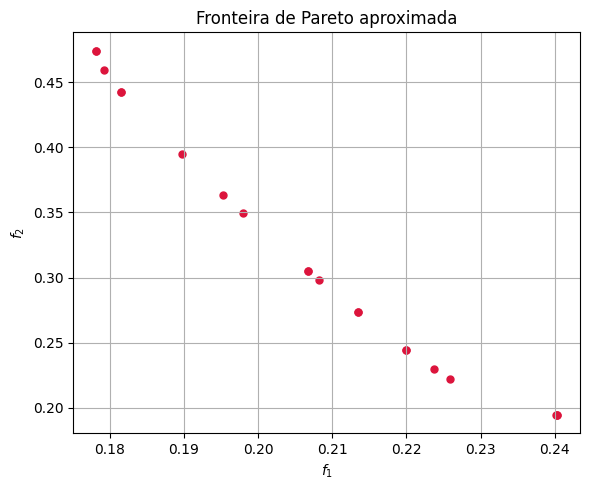

In [ ]:
# %% 9 — Plots
# Fronteira aproximada
F = np.array([ind.fitness.values for ind in pareto_pop])
plt.figure(figsize=(6,5))
plt.scatter(F[:,0], F[:,1], s=25, c="crimson")
plt.title("Fronteira de Pareto aproximada")
plt.xlabel("$f_1$"); plt.ylabel("$f_2$")
plt.grid(True); plt.tight_layout(); plt.show()
